# Set up

In [1]:
import glob
import datetime as dt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import pytz
import pprint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model data

## Review features

In [75]:
# get data acquired and cleaned
flights3=pd.read_pickle('./data/flights3.pkl')

In [76]:
# convert to float such that it cen be used in regression model
flights3['DEP_TIME_F']=flights3['DEP_TIME'].astype('float64')

### Pick features to use

In [81]:
flights3.shape

(5380112, 29)

In [82]:
flights3.columns

Index(['MONTH', 'DAY_OF_MONTH', 'FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'ORIGIN',
       'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ORIG_FLIGHTS_DEPART_VOL', 'ORIGIN_TIMEZONE',
       'DEP_DT', 'ARR_DT', 'TZ', 'DEP_DT_UTC', 'INBOUND_DELAY', 'PREV_ARR_DT',
       'PREV_ARR_DT_UTC', 'TURNAROUND_TIME', 'Temp_F', 'WindSpeed', 'Precip',
       'MEAN_PRECIP', 'Precip_df', 'DEP_TIME_F'],
      dtype='object')

In [83]:
smaller_df=flights3[['DEP_DELAY', 'INBOUND_DELAY', 'MONTH', 'ORIG_FLIGHTS_DEPART_VOL', 'TURNAROUND_TIME',
                   'DEP_TIME_F','Temp_F', 'WindSpeed','Precip']]

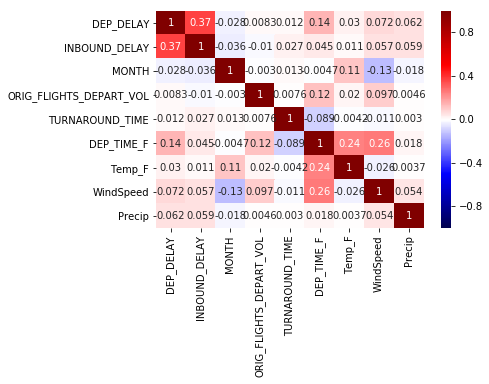

In [84]:
sns.heatmap(smaller_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [190]:
# from correlation matrix, pick highest correlated features without collinearity
flights4=flights3[['DEP_DELAY', 'INBOUND_DELAY', 'MONTH', 'ORIG_FLIGHTS_DEPART_VOL', 'TURNAROUND_TIME',
                   'DEP_TIME_F','Temp_F', 'WindSpeed','Precip']]

## Perform train/val split

In [191]:
# Randomly sample to 50000
#X=flights4.iloc[:,1:]
#y=flights4.iloc[:,0]
sampled=flights4.sample(n=50000, random_state=15)
X=sampled.iloc[:,1:]
y=sampled.iloc[:,0]
print(X.shape)
print(y.shape)

(50000, 8)
(50000,)


(array([4.8819e+04, 1.0060e+03, 1.1900e+02, 1.6000e+01, 1.4000e+01,
        1.1000e+01, 1.0000e+01, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ -47. ,  116.2,  279.4,  442.6,  605.8,  769. ,  932.2, 1095.4,
        1258.6, 1421.8, 1585. ]),
 <a list of 10 Patch objects>)

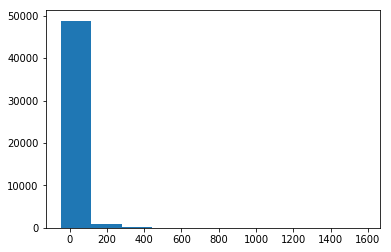

In [192]:
plt.hist(y)

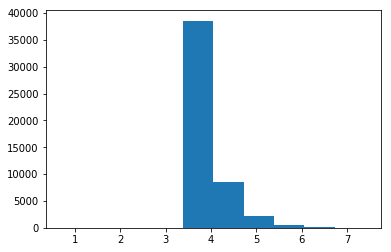

In [193]:
# Transform y because of light tail residual plot
y_t=np.log1p(y-y.min()+1)

plt.hist(y_t);

In [194]:
y=y_t

### Split into Train, Validatie, Test Sets

In [195]:
# set up train, validation, and test data sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

### Run pipelines for various regression CV models

In [196]:
# set up function to show all relevant results from model in one go
def modelResults(model, test_set_pred, y_test):
    r2_test = r2_score(y_test, test_set_pred)
    print('R2 is: '+str(r2_test))
    print('Alpha is: '+str(model.alpha_))
    pprint.pprint(list(zip(X_test.columns, model.coef_)))
    
    data=pd.DataFrame()
    data['predict']=test_set_pred
    data['resid']=y_test - data.predict
    with sns.axes_style('white'):
        sns.jointplot(x="predict", y="resid", data=data)
    
    df=pd.concat([data['resid'], X_train_val], axis=1)
    
    fig = plt.figure()
    stats.probplot(data['resid'], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()
    

R2 is: 0.19980056680754832
Alpha is: 0.01
[('INBOUND_DELAY', 0.1327227129433967),
 ('MONTH', -0.0),
 ('ORIG_FLIGHTS_DEPART_VOL', 0.0),
 ('TURNAROUND_TIME', 0.0),
 ('DEP_TIME_F', 0.06356439163299724),
 ('Temp_F', 0.0),
 ('WindSpeed', 0.004366349009494419),
 ('Precip', 0.01039347357855417)]


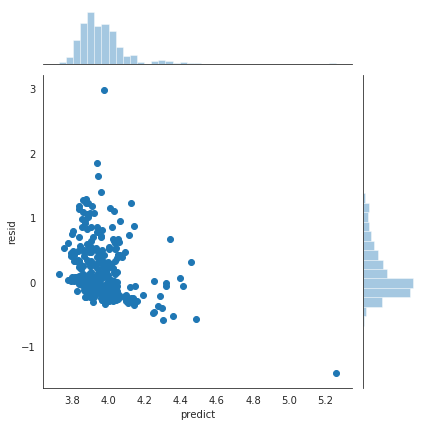

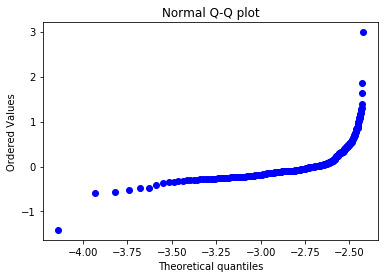

In [197]:
# LassoCV Results
# set up alpha vector 
alphavec = 10**np.linspace(-2,2,200)

steps = [('standardize', StandardScaler()), 
         ('LassoCV', LassoCV(alphas = alphavec, cv=5))]

lasso_pipe = Pipeline(steps)
lasso_pipe.fit(X_train_val.values, y_train_val)
data_set_pred = lasso_pipe.predict(X_train_val.values)

modelResults(lasso_pipe.named_steps['LassoCV'], data_set_pred, y_train_val)

R2 is: 0.2013089433251557
Alpha is: 107.22672220103232
[('INBOUND_DELAY', 0.14166293231216684),
 ('DEP_TIME_F', 0.07394836689874444),
 ('Precip', 0.01982970659825154)]


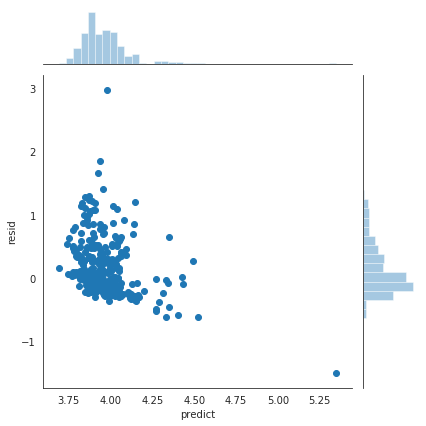

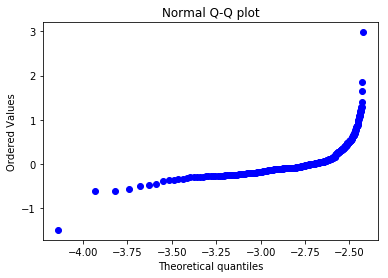

In [187]:
# RidgeCV Results
# set up alpha vector 
alphavec= 10**np.linspace(1,7,100)

steps = [('standardize', StandardScaler()), 
         ('ridgeCV', RidgeCV(alphas = alphavec, cv=5))]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train_val.values, y_train_val)
data_set_pred = ridge_pipe.predict(X_train_val.values)

modelResults(ridge_pipe.named_steps['ridgeCV'], data_set_pred, y_train_val)

R2 is: 0.20072011463816353
Alpha is: 0.01
[('INBOUND_DELAY', 0.13682025527639172),
 ('DEP_TIME_F', 0.06911060092853474),
 ('Precip', 0.015214695617128283)]


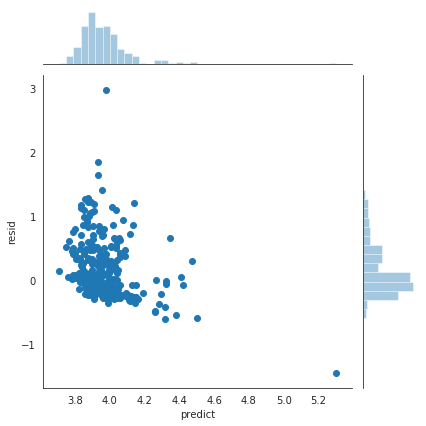

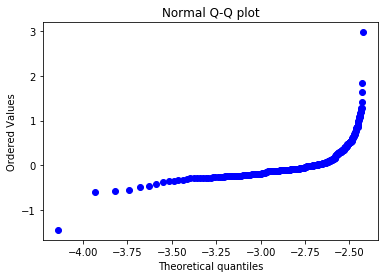

In [189]:
# ElasticNetCV Results 
steps = [('standardize', StandardScaler()), 
         ('ElasticNetCV', ElasticNetCV(alphas = alphavec, cv=5))]

elastic_pipe = Pipeline(steps)
elastic_pipe.fit(X_train_val.values, y_train_val)
data_set_pred = elastic_pipe.predict(X_train_val.values)

modelResults(elastic_pipe.named_steps['ElasticNetCV'], data_set_pred, y_train_val)

## Results from Selected Model on Test Data

R2 is: 0.232550123639379
Alpha is: 107.22672220103232
[('INBOUND_DELAY', 0.14166293231216684),
 ('DEP_TIME_F', 0.07394836689874444),
 ('Precip', 0.01982970659825154)]


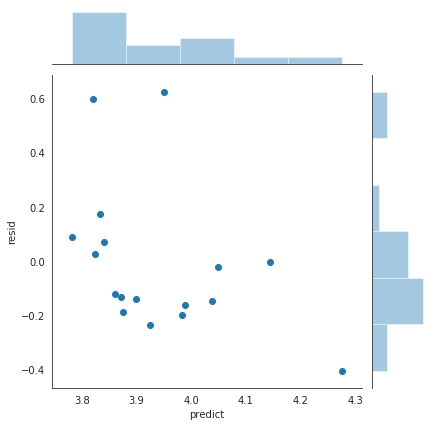

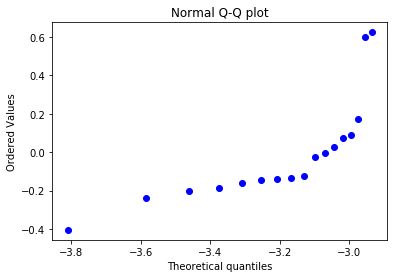

In [183]:
alphavec= 10**np.linspace(1,7,100)

data_set_pred = ridge_pipe.predict(X_test.values)

modelResults(ridge_pipe.named_steps['ridgeCV'], data_set_pred, y_test)